# Introduction

Pneumonia is a lung infection that can be life-threatening, especially for children, older adults, and those with weakened immune systems. Early and accurate detection is crucial for effective treatment, but diagnosing pneumonia often relies on analyzing chest X-rays, which requires skilled radiologists. Unfortunately, in many areas, such expertise is not readily available. <br/>
This project seeks to train a model to analyze chest X-rays and detect pneumonia accurately. By leveraging a public dataset of labeled chest X-ray images and employing two advanced machine learning models, ResNet-34 and DenseNet-121, in an ensemble approach, the project aims to improve diagnostic accuracy and provide a scalable, cost-effective solution to support pneumonia diagnosis.

# Step 0: Set Up

In this part, we sets up an environment for machine learning workflows using AWS SageMaker and Kaggle Hub. It installs necessary libraries (`sagemaker` and `kagglehub`) and imports essential modules for data manipulation, image processing, and visualization. <br/>
A SageMaker session is created to interact with AWS services, with the default S3 bucket being retrieved for storing data and model artifacts. The IAM execution role for the SageMaker instance is also fetched, enabling access to AWS resources.

In [1]:
# Import Library
!pip install sagemaker
!pip install kagglehub
import kagglehub
import sagemaker
import boto3
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sagemaker.pytorch import PyTorch

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[12/29/24 10:34:06] INFO     Found credentials from IAM Role:                                   ]8;id=927497;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=861565;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[12/29/24 10:34:18] INFO     generated new fontManager                                         ]8;id=644610;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=888230;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1584\1584]8;;\

In [2]:
# Create a SageMaker session
sagemaker_session = sagemaker.Session()

# Get the default bucket
default_bucket = sagemaker_session.default_bucket()
print(f"Default S3 Bucket: {default_bucket}")

# Get the execution role
role = sagemaker.get_execution_role()
print(f"SageMaker Execution Role: {role}")

[12/29/24 09:02:08] INFO     Found credentials from IAM Role:                                   ]8;id=786411;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=322493;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Default S3 Bucket: sagemaker-us-east-1-922513202163


[12/29/24 09:02:09] INFO     Found credentials from IAM Role:                                   ]8;id=569995;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=666430;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

SageMaker Execution Role: arn:aws:iam::922513202163:role/service-role/AmazonSageMaker-ExecutionRole-20241222T200167


# Step 1: Dataset Exploration and Visualization

This code below will explore and visualize the **Chest X-Ray Pneumonia Dataset** by perfoming:

1. Downloads the dataset using the `kagglehub` library.
2. Extracts and summarizes the dataset by counting the number of images for each class (e.g., Normal, Pneumonia).
3. Displays statistical information for training, testing, and validation datasets.
4. Samples and visualizes a few images for each class.

In [3]:
#Download Dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

Path to dataset files: /home/ec2-user/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [4]:
# Define the dataset path
train_path = os.path.join(path, "chest_xray", "train")
test_path = os.path.join(path, "chest_xray", "test")
val_path = os.path.join(path, "chest_xray", "val")

In [5]:
# Explore dataset
def explore_data(directory):
    classes = os.listdir(directory)
    data = []
    for class_label in classes:
        class_path = os.path.join(directory, class_label)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            data.append({
                "Class": class_label,
                "Num_Images": len(image_files)
            })
    return pd.DataFrame(data)

# Explore train, test, and validation datasets
train_stats = explore_data(train_path)
test_stats = explore_data(test_path)
val_stats = explore_data(val_path)

Visualizing Training Data Distribution:


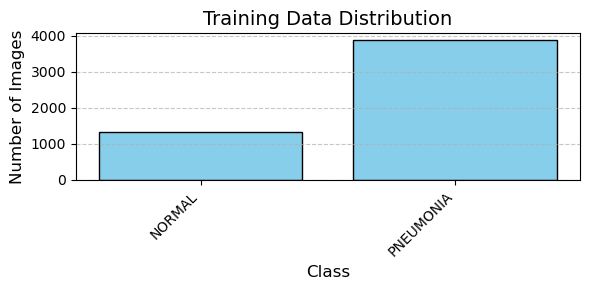

Visualizing Testing Data Distribution:


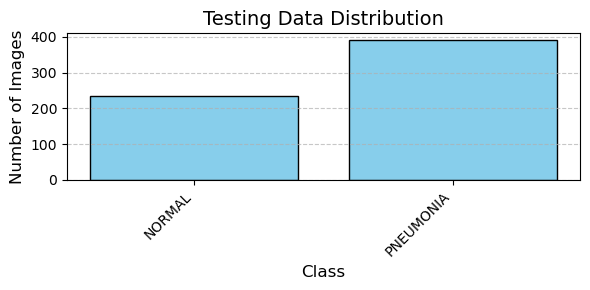

Visualizing Validation Data Distribution:


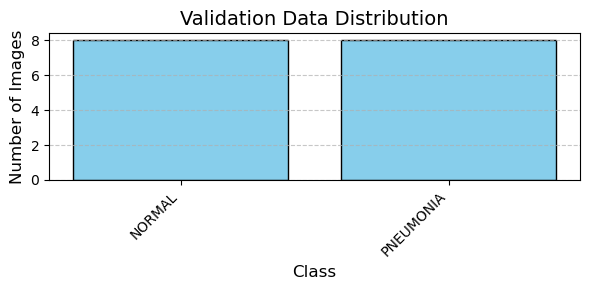

In [6]:
# Visualization
def visualize_distribution(stats, title):
    plt.figure(figsize=(6, 3))
    plt.bar(stats['Class'], stats['Num_Images'], color='skyblue', edgecolor='black')
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

print("Visualizing Training Data Distribution:")
visualize_distribution(train_stats, "Training Data Distribution")

print("Visualizing Testing Data Distribution:")
visualize_distribution(test_stats, "Testing Data Distribution")

print("Visualizing Validation Data Distribution:")
visualize_distribution(val_stats, "Validation Data Distribution")

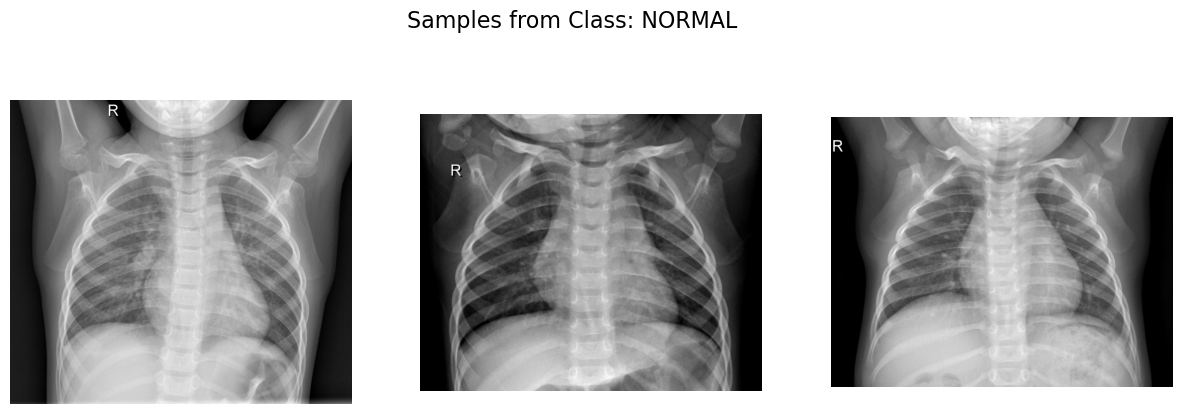

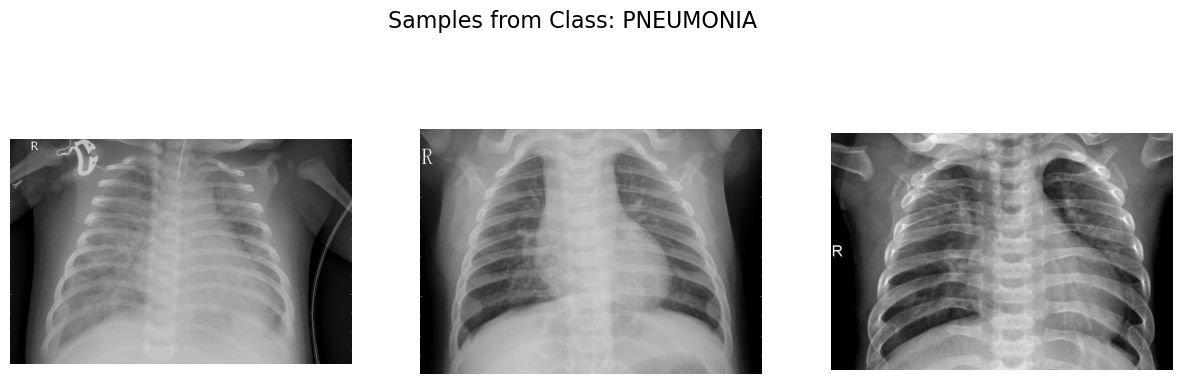

In [7]:
# Sampling and visualizing the data
def sample_images_combined(directory, class_label, num_samples=3):
    class_path = os.path.join(directory, class_label)
    image_files = os.listdir(class_path)[:num_samples]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Samples from Class: {class_label}", fontsize=16)
    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path)
        axes[idx].imshow(image, cmap='gray')
        axes[idx].axis('off')
    for idx in range(len(image_files), 3):
        axes[idx].axis('off')
    plt.show()

for class_label in os.listdir(train_path):
    if os.path.isdir(os.path.join(train_path, class_label)):
        sample_images_combined(train_path, class_label, num_samples=3)

In [8]:
# Upload Data to S3
!aws s3 sync $train_path s3://$default_bucket/train --quiet
!aws s3 sync $test_path s3://$default_bucket/test --quiet
!aws s3 sync $val_path s3://$default_bucket/val --quiet

In [9]:
# Create label file 
s3 = boto3.client("s3")
prefixes_train = {"train/NORMAL/": 0,"train/PNEUMONIA/": 1}
prefixes_test = {"test/NORMAL/": 0,"test/PNEUMONIA/": 1}
prefixes_val = {"val/NORMAL/": 0,"val/PNEUMONIA/": 1}
output_file_train = "train.txt"
output_file_test = "test.txt"
output_file_val = "val.txt"
def create_label_file(prefixes, output_file):
    with open(output_file, "w") as file:
        for prefix, label in prefixes.items():
            paginator = s3.get_paginator("list_objects_v2")
            for page in paginator.paginate(Bucket=default_bucket, Prefix=prefix):
                for obj in page.get("Contents", []):
                    filename = obj["Key"]
                    if filename.endswith(".jpeg"):
                        file.write(f"s3://{default_bucket}/{filename},{label}\n")
create_label_file(prefixes_train, output_file_train)
create_label_file(prefixes_test, output_file_test)
create_label_file(prefixes_val, output_file_val)
!aws s3 cp ./train.txt s3://$default_bucket/train.txt --quiet
!aws s3 cp ./test.txt s3://$default_bucket/test.txt --quiet
!aws s3 cp ./val.txt s3://$default_bucket/val.txt --quiet

[12/29/24 02:38:35] INFO     Found credentials from IAM Role:                                   ]8;id=845766;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=163295;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

# Step 2: Benchmark model training

In this part, we trains a benchmark model using a pre-trained ResNet-34 architecture in AWS SageMaker with specified training and testing datasets stored in S3.<br/>
The model leverages the PyTorch framework and is configured with essential hyperparameters such as a learning rate of 0.002, a batch size of 32, and 10 training epochs. Input data paths are provided for both training and testing datasets, along with their corresponding labels.<br/>
The model is deployed on an `ml.p3.2xlarge` instance, which provides GPU acceleration for efficient training of the ResNet-34 model. This setup aims to benchmark the performance of the pre-trained ResNet-34 on the given dataset.

In [4]:
inputs = {
    'train': f's3://{default_bucket}/train/',
    'trainlabel': f's3://{default_bucket}/train.txt',
    'test': f's3://{default_bucket}/test/',
    'testlabel': f's3://{default_bucket}/test.txt'
}

In [17]:
# Train Bench mark
estimator = PyTorch(
    entry_point='train_script.py',
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    framework_version='1.5.0',
    py_version='py3',
    script_mode=True,
    hyperparameters={'learning_rate': 0.002, 'batch_size': 64, 'epochs': 10},
    output_path=f's3://{default_bucket}/output'
)
estimator.fit(inputs)

[12/29/24 06:18:19] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=206129;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=303714;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=458683;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=733644;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#675\675]8;;\
                             instance_type, framework etc.                                                         

[12/29/24 06:18:20] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=84041;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=80969;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#675\675]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=39253;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=495947;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2024-12-29-06-18-19-962                                              

2024-12-29 06:18:20 Starting - Starting the training job
2024-12-29 06:18:20 Pending - Training job waiting for capacity......
2024-12-29 06:19:04 Pending - Preparing the instances for training......
2024-12-29 06:19:56 Downloading - Downloading input data...
2024-12-29 06:20:42 Downloading - Downloading the training image.........
2024-12-29 06:22:18 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-12-29 06:22:32,581 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-12-29 06:22:32,613 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-12-29 06:22:32,615 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-12-29 06:22:32,883 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": 

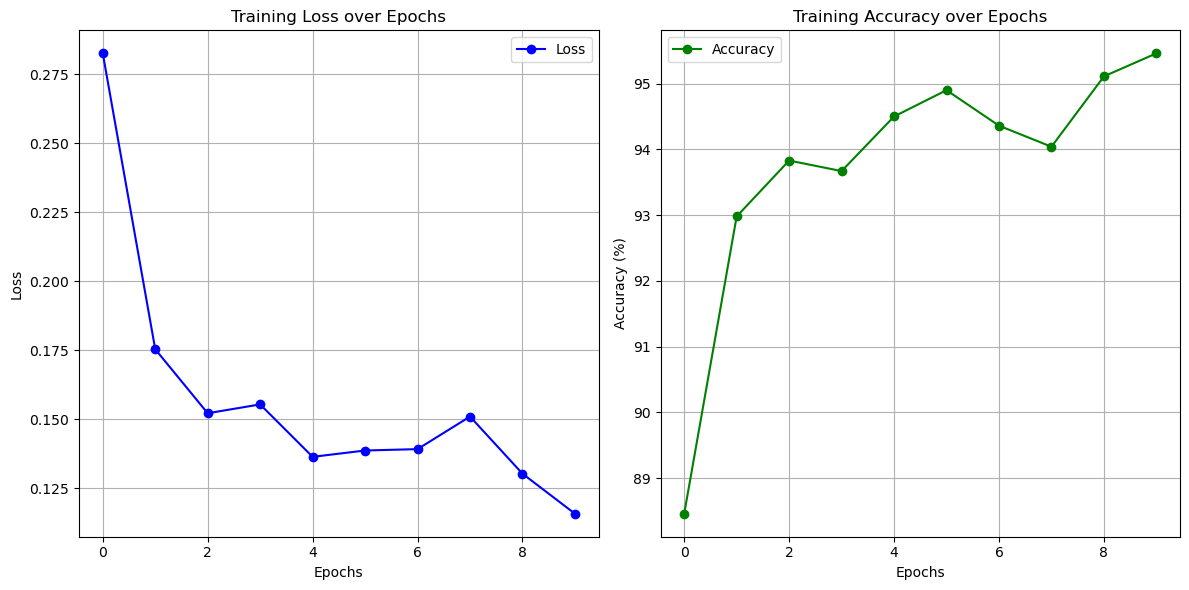

In [20]:
# Result Visualization
# Training data
epochs = list(range(10))
loss = [0.2826, 0.1754, 0.1522, 0.1554, 0.1364, 0.1387, 0.1392, 0.1510, 0.1303, 0.1158]
accuracy = [88.46, 92.98, 93.83, 93.67, 94.50, 94.90, 94.36, 94.04, 95.11, 95.46]

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, marker='o', label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Conclusion on Benchmark Model Performance

The benchmark model above demonstrates strong performance during training, achieving a training accuracy of 95.46% by the final epoch with a steadily decreasing loss, indicating effective learning. However, the validation accuracy is slightly lower at 83.17%, suggesting a potential generalization gap that might require further optimization or regularization techniques.

In terms of precision, recall, and F1 score, the model performs well, achieving values of 0.8559, 0.8317, and 0.8198, respectively. This indicates that the model strikes a reasonable balance between identifying true positives and minimizing false positives and false negatives.

# Step 3: Train Combined Model

To compare it with the benchmark model, we will train a combined model that incorporates both ResNet and DenseNet architectures. By leveraging the strengths of these two powerful models, we aim to further improve the accuracy of our predictions.

In [ ]:
estimator_combined = PyTorch(
    entry_point='train_script_combined2.py',
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    framework_version='1.5.0',
    py_version='py3',
    script_mode=True,
    hyperparameters={'learning_rate': 0.002, 'batch_size': 64, 'epochs': 5},
    output_path=f's3://{default_bucket}/output'
)
estimator_combined.fit(inputs)

[12/29/24 07:53:26] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=527525;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=141108;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=314513;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=914196;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#675\675]8;;\
                             instance_type, framework etc.                                                         

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=370753;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=687749;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#675\675]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=806894;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=894856;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2024-12-29-07-53-26-653                                              

2024-12-29 07:53:27 Starting - Starting the training job
2024-12-29 07:53:27 Pending - Training job waiting for capacity......
2024-12-29 07:54:12 Pending - Preparing the instances for training...
2024-12-29 07:54:52 Downloading - Downloading input data......
2024-12-29 07:55:37 Downloading - Downloading the training image...Epoch 0: Loss 0.2711, Accuracy 88.44%
Epoch 1: Loss 0.1591, Accuracy 94.13%
Epoch 2: Loss 0.1447, Accuracy 94.10%
Epoch 3: Loss 0.1390, Accuracy 94.57%
Epoch 4: Loss 0.1321, Accuracy 94.67%
Training DenseNet Model...
Epoch 0: Loss 0.1476, Accuracy 93.85%
Epoch 1: Loss 0.0788, Accuracy 96.86%
Epoch 2: Loss 0.0800, Accuracy 97.07%
Epoch 3: Loss 0.0725, Accuracy 97.26%
Epoch 4: Loss 0.0660, Accuracy 97.62%
Testing Combined Models...
Validation Accuracy: 79.1667%
Precision: 0.8408
Recall: 0.7917
F1 Score: 0.7671
Models saved successfully.
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
#01

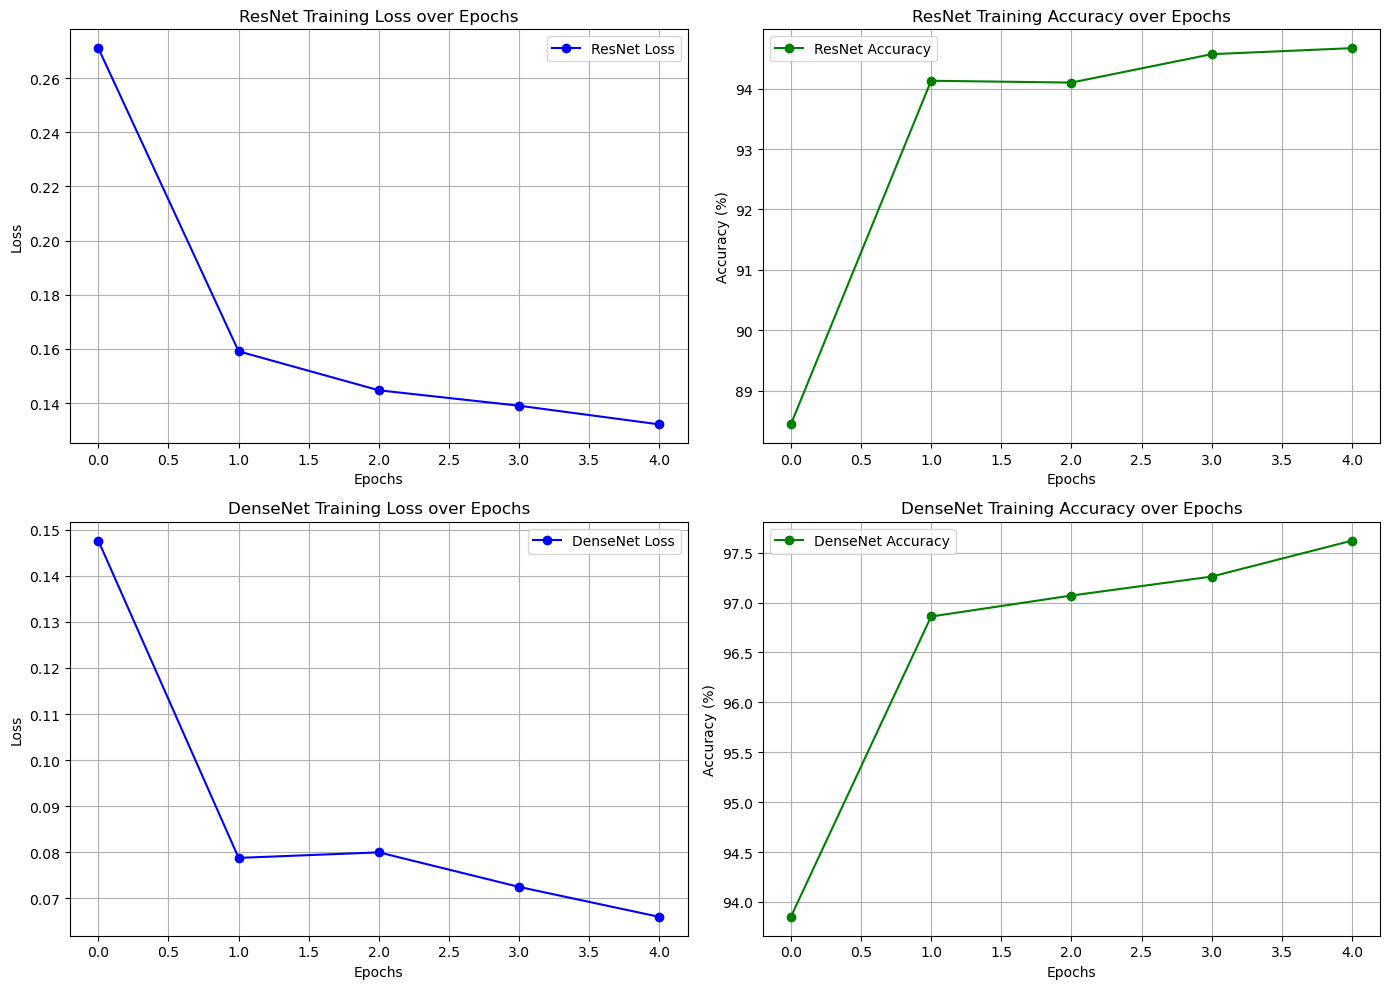

In [22]:
# ResNet training data
resnet_epochs = list(range(5))
resnet_loss = [0.2711, 0.1591, 0.1447, 0.1390, 0.1321]
resnet_accuracy = [88.44, 94.13, 94.10, 94.57, 94.67]

# DenseNet training data
densenet_epochs = list(range(5))
densenet_loss = [0.1476, 0.0788, 0.0800, 0.0725, 0.0660]
densenet_accuracy = [93.85, 96.86, 97.07, 97.26, 97.62]

plt.figure(figsize=(14, 10))

# ResNet Loss
plt.subplot(2, 2, 1)
plt.plot(resnet_epochs, resnet_loss, marker='o', label='ResNet Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet Training Loss over Epochs')
plt.grid(True)
plt.legend()

# ResNet Accuracy
plt.subplot(2, 2, 2)
plt.plot(resnet_epochs, resnet_accuracy, marker='o', label='ResNet Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('ResNet Training Accuracy over Epochs')
plt.grid(True)
plt.legend()

# DenseNet Loss
plt.subplot(2, 2, 3)
plt.plot(densenet_epochs, densenet_loss, marker='o', label='DenseNet Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('DenseNet Training Loss over Epochs')
plt.grid(True)
plt.legend()

# DenseNet Accuracy
plt.subplot(2, 2, 4)
plt.plot(densenet_epochs, densenet_accuracy, marker='o', label='DenseNet Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('DenseNet Training Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Combined Model Analysis

In the training above, ResNet and DenseNet were trained separately, using the same datasets but with their unique architectures and configurations. The training process for ResNet involved optimizing its parameters over five epochs, where the model steadily improved its accuracy. DenseNet, with its densely connected layers, exhibited faster convergence and higher accuracy in fewer epochs.

After individual training, a combined evaluation was performed using a weighted averaging approach, where the outputs of both models were combined with weights (ResNet * 2 and DenseNet * 1). This method aimed to leverage the strengths of both architectures—ResNet’s robustness and DenseNet’s efficiency. Despite DenseNet achieving superior training accuracy, the combined model did not generalize as effectively as ResNet alone, as evidenced by its lower validation accuracy and F1 score. This outcome suggests that the weighting in the ensemble approach could be further optimized or that ResNet alone may be better suited for the given dataset.

# Step 4: Increase training epoches

In this section, we will increase the number of training epochs to 10, ensuring that each model is trained for a total of 10 epochs.

In [ ]:
estimator_combined2 = PyTorch(
    entry_point='train_script_combined2.py',
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    framework_version='1.5.0',
    py_version='py3',
    script_mode=True,
    hyperparameters={'learning_rate': 0.002, 'batch_size': 64, 'epochs': 10},
    output_path=f's3://{default_bucket}/output'
)
estimator_combined2.fit(inputs)

[12/29/24 09:02:30] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=473038;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=527464;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=288807;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=657298;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#675\675]8;;\
                             instance_type, framework etc.                                                         

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=325347;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=959555;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#675\675]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=602600;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=993888;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2024-12-29-09-02-30-718                                              

2024-12-29 09:02:31 Starting - Starting the training job
2024-12-29 09:02:31 Pending - Training job waiting for capacity......
2024-12-29 09:03:13 Pending - Preparing the instances for training...
2024-12-29 09:03:58 Downloading - Downloading input data......
2024-12-29 09:04:48 Downloading - Downloading the training image.........
2024-12-29 09:06:15 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-12-29 09:06:36,195 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-12-29 09:06:36,227 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-12-29 09:06:36,230 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-12-29 09:06:36,495 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {

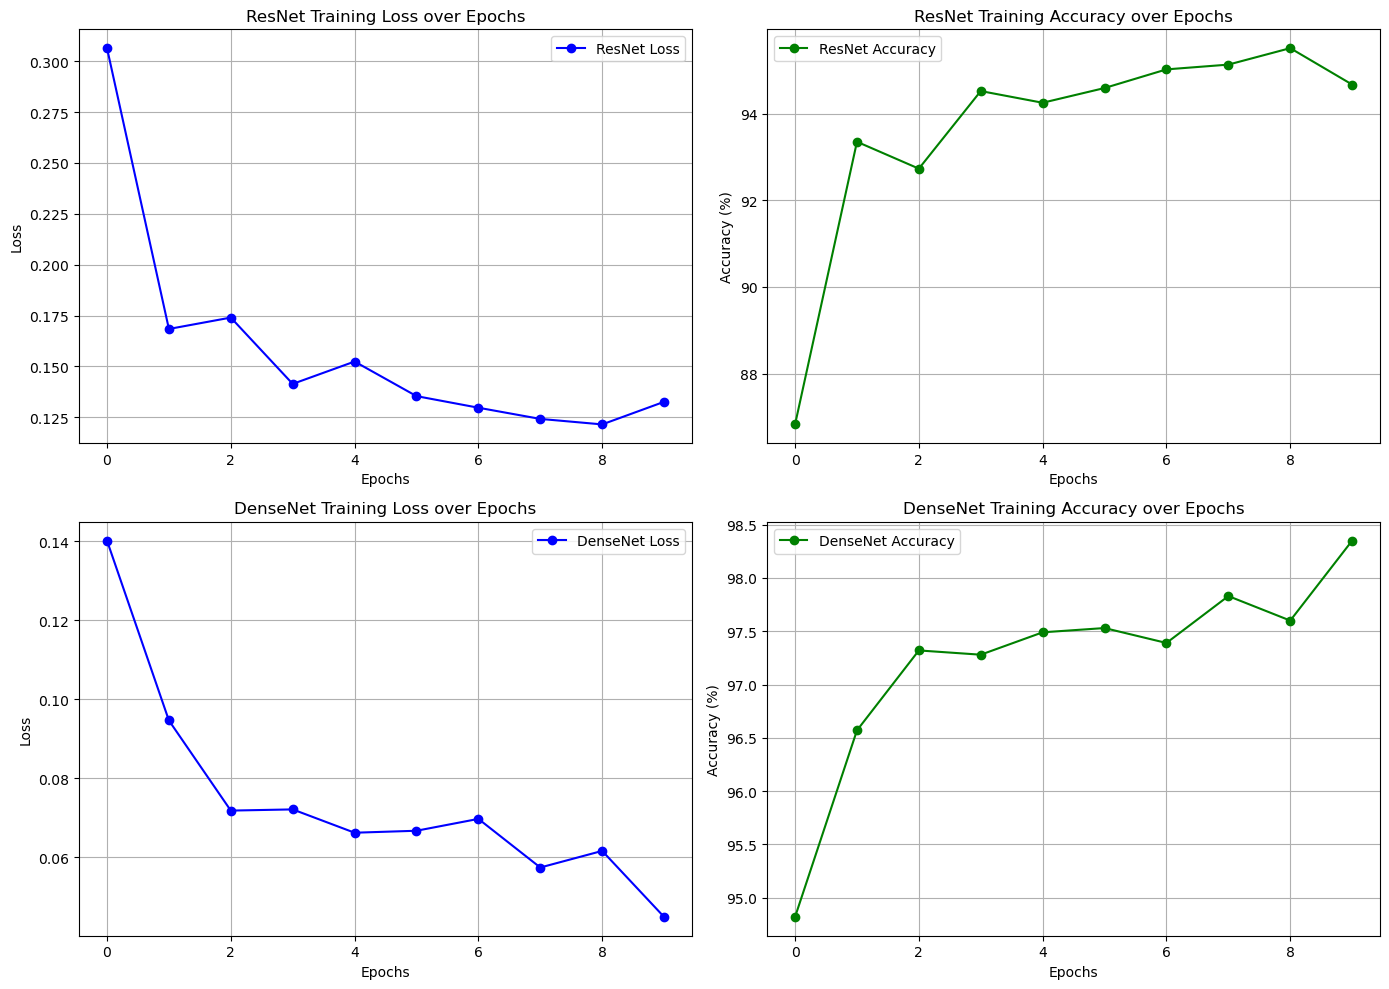

In [2]:
# ResNet training data
resnet_epochs = list(range(10))
resnet_loss = [0.3064, 0.1684, 0.1740, 0.1414, 0.1524, 0.1354, 0.1297, 0.1242, 0.1215, 0.1326]
resnet_accuracy = [86.83, 93.35, 92.73, 94.52, 94.25, 94.59, 95.02, 95.13, 95.51, 94.67]

# DenseNet training data
densenet_epochs = list(range(10))
densenet_loss = [0.1401, 0.0946, 0.0718, 0.0721, 0.0662, 0.0667, 0.0697, 0.0574, 0.0616, 0.0449]
densenet_accuracy = [94.82, 96.57, 97.32, 97.28, 97.49, 97.53, 97.39, 97.83, 97.60, 98.35]

plt.figure(figsize=(14, 10))

# ResNet Loss
plt.subplot(2, 2, 1)
plt.plot(resnet_epochs, resnet_loss, marker='o', label='ResNet Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet Training Loss over Epochs')
plt.grid(True)
plt.legend()

# ResNet Accuracy
plt.subplot(2, 2, 2)
plt.plot(resnet_epochs, resnet_accuracy, marker='o', label='ResNet Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('ResNet Training Accuracy over Epochs')
plt.grid(True)
plt.legend()

# DenseNet Loss
plt.subplot(2, 2, 3)
plt.plot(densenet_epochs, densenet_loss, marker='o', label='DenseNet Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('DenseNet Training Loss over Epochs')
plt.grid(True)
plt.legend()

# DenseNet Accuracy
plt.subplot(2, 2, 4)
plt.plot(densenet_epochs, densenet_accuracy, marker='o', label='DenseNet Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('DenseNet Training Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Combined Model Analysis 2

Training the models for 10 epochs instead of 5 showed clear improvements in their performance. For ResNet, accuracy increased from 94.67% after 5 epochs to 95.51% after 10 epochs. DenseNet also improved, with accuracy rising from 97.62% to 98.35% after 10 epochs. The longer training helped both models fine-tune their parameters and perform better.

For the combined models, training for 10 epochs slightly improved validation accuracy from 79.17% to 79.81%. Precision, recall, and F1 score also improved a little. This shows that longer training helps individual models more, while the combined model's improvement was smaller, possibly due to limits in the way the models were combined or the dataset itself.

# Step 5: Conclusion

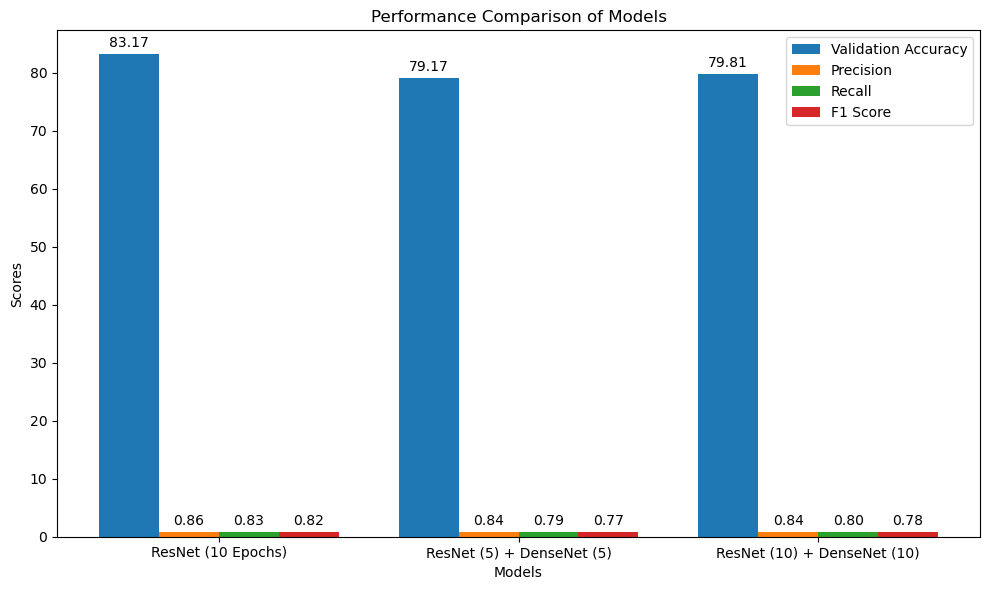

In [4]:
# Data for visualization
models = ["ResNet (10 Epochs)", "ResNet (5) + DenseNet (5)", "ResNet (10) + DenseNet (10)"]
validation_accuracy = [83.1731, 79.1667, 79.8077]
precision = [0.8559, 0.8408, 0.8446]
recall = [0.8317, 0.7917, 0.7981]
f1_score = [0.8198, 0.7671, 0.7755]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width * 1.5, validation_accuracy, width, label='Validation Accuracy')
rects2 = ax.bar(x - width / 2, precision, width, label='Precision')
rects3 = ax.bar(x + width / 2, recall, width, label='Recall')
rects4 = ax.bar(x + width * 1.5, f1_score, width, label='F1 Score')

# Add text for labels, title, and axes ticks
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add bar labels
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',  # Text to display
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # Position of the text
                    xytext=(0, 3),  # Offset text above the bar
                    textcoords="offset points",  # Use offset from the bar as coordinates
                    ha='center', va='bottom')  # Center alignment

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

plt.tight_layout()
plt.show()

The comparison between training ResNet alone and combining ResNet with DenseNet shows that combining the models did not significantly improve accuracy. ResNet trained alone for 10 epochs reached a validation accuracy of 83.17%, while the combined models, even with both trained for 10 epochs, only achieved 79.81%. 
<br/>Metrics like precision, recall, and F1 score were slightly better for the combined models than when training them for 5 epochs each but still lower than ResNet alone. This suggests that combining the models may have introduced conflicting predictions or redundancy, and ResNet’s strong ability to generalize made it more effective on its own.
<br/>Since ResNet alone performed better and was simpler to use, it was concluded that ResNet alone provided a strong and effective solution, and combining the models added unnecessary complexity without meaningful improvement.